# Extended Kalman Filter (EKF): Robot Navigasi dengan GPS dan IMU

Tujuan EKF: Memperkirakan posisi dan orientasi robot secara optimal dengan memanfaatkan linierisasi data dari sensor (misalnya GPS dan IMU).



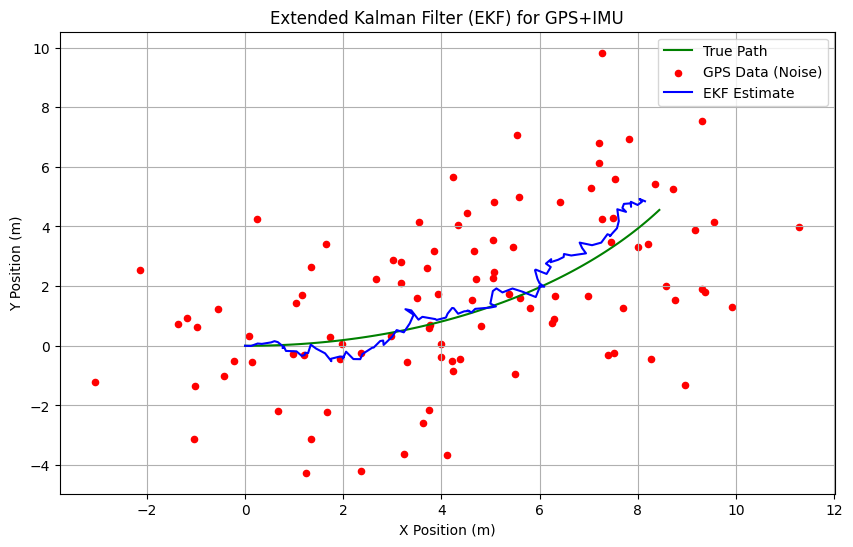

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter EKF
dt = 0.1  # Waktu langkah
state = np.array([0, 0, 0])  # [x, y, theta] posisi awal
covariance = np.eye(3) * 0.1  # Covariance matrix awal
process_noise = np.diag([0.01, 0.01, 0.001])  # Proses noise (Q)
measurement_noise = np.diag([5, 5])  # Noise GPS (R)

# Model Gerak
def motion_model(state, control, dt):
    x, y, theta = state
    v, omega = control
    x_new = x + v * np.cos(theta) * dt
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + omega * dt
    return np.array([x_new, y_new, theta_new])

# Jacobian untuk model gerak
def jacobian_motion(state, control, dt):
    _, _, theta = state
    v, _ = control
    F = np.array([
        [1, 0, -v * np.sin(theta) * dt],
        [0, 1,  v * np.cos(theta) * dt],
        [0, 0,  1]
    ])
    return F

# Model Pengamatan (GPS)
def measurement_model(state):
    return state[:2]

# Jacobian untuk pengamatan
def jacobian_measurement():
    return np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

# Data GPS dan IMU Simulasi
np.random.seed(42)
true_positions = [np.array([0, 0, 0])]
gps_data = []
imu_controls = []

for t in range(100):
    # Kontrol IMU (kecepatan linear dan sudut)
    v = 1.0
    omega = 0.1
    imu_controls.append([v, omega])

    # Posisi sebenarnya
    true_position = motion_model(true_positions[-1], [v, omega], dt)
    true_positions.append(true_position)

    # Data GPS dengan noise
    gps = measurement_model(true_position) + np.random.multivariate_normal([0, 0], measurement_noise)
    gps_data.append(gps)

# EKF Implementasi
estimated_positions = [state]
for i in range(len(gps_data)):
    # Predict step
    control = imu_controls[i]
    state_pred = motion_model(estimated_positions[-1], control, dt)
    F = jacobian_motion(estimated_positions[-1], control, dt)
    covariance_pred = F @ covariance @ F.T + process_noise

    # Update step
    z = gps_data[i]
    H = jacobian_measurement()
    y = z - measurement_model(state_pred)
    S = H @ covariance_pred @ H.T + measurement_noise
    K = covariance_pred @ H.T @ np.linalg.inv(S)

    state_est = state_pred + K @ y
    covariance = (np.eye(3) - K @ H) @ covariance_pred
    estimated_positions.append(state_est)

# Plot Hasil
true_positions = np.array(true_positions)
gps_data = np.array(gps_data)
estimated_positions = np.array(estimated_positions)

plt.figure(figsize=(10, 6))
plt.plot(true_positions[:, 0], true_positions[:, 1], 'g-', label='True Path')
plt.scatter(gps_data[:, 0], gps_data[:, 1], c='r', s=20, label='GPS Data (Noise)')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], 'b-', label='EKF Estimate')
plt.legend()
plt.title("Extended Kalman Filter (EKF) for GPS+IMU")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()

Hasil Analisis Output: Hasil simulasi Extended Kalman Filter (EKF) menunjukkan bahwa filter ini mampu memberikan estimasi posisi robot yang mendekati jalur sebenarnya (True Path) meskipun data GPS mengandung noise signifikan. Garis hijau menggambarkan jalur sebenarnya dari robot, sementara titik merah menunjukkan data GPS dengan noise yang tersebar acak di sekitar jalur. EKF berhasil menggabungkan data GPS dan IMU melalui proses prediksi dan koreksi, menghasilkan estimasi yang lebih halus dan akurat, ditandai oleh garis biru yang mengikuti jalur hijau secara konsisten. Hal ini membuktikan bahwa EKF efektif dalam mengurangi pengaruh noise dan memberikan hasil estimasi yang optimal dalam skenario navigasi dengan GPS dan IMU.

# Unscented Kalman Filter (UKF) untuk Estimasi Navigasi Robot Menggunakan Data GPS dan IMU

Tujuan UKF: Mengestimasi posisi dan orientasi robot dalam sistem non-linear menggunakan sigma points untuk meningkatkan akurasi tanpa memerlukan Jacobian.

In [ ]:
# Install FilterPy
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=042ff4685211b423c2ddd2b38bee0d8a70c39c52027e627fab44e45f9b322bde
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


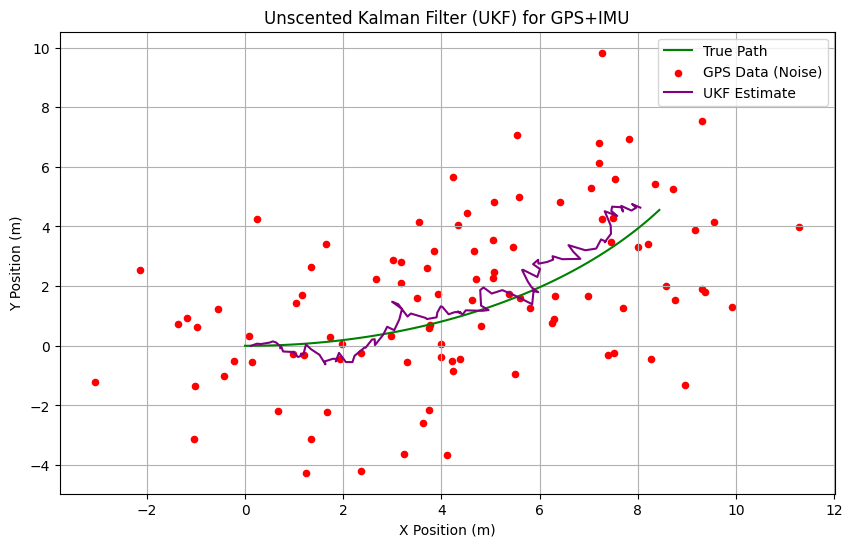

In [ ]:
# Import modul yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# UKF Setup
def fx(state, dt, control):
    x, y, theta = state
    v, omega = control
    x_new = x + v * np.cos(theta) * dt
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + omega * dt
    return np.array([x_new, y_new, theta_new])

def hx(state):
    return state[:2]  # Observasi (x, y)

# Sigma points untuk UKF
points = MerweScaledSigmaPoints(n=3, alpha=0.1, beta=2., kappa=1)
ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=hx, dt=0.1, points=points)
ukf.x = np.array([0., 0., 0.])  # State awal
ukf.P *= 0.1
ukf.Q = np.diag([0.01, 0.01, 0.01])  # Noise proses
ukf.R = np.diag([5, 5])  # Noise pengamatan GPS

# Simulasi Data
np.random.seed(42)
dt = 0.1
gps_data = []
controls = []
true_states = [np.array([0, 0, 0])]

for t in range(100):
    # Kontrol gerakan (kecepatan dan rotasi)
    control = np.array([1.0, 0.1])
    controls.append(control)


    # Gerak robot sebenarnya
    true_state = fx(true_states[-1], dt, control)
    true_states.append(true_state)

    # Pengamatan GPS dengan noise
    gps = true_state[:2] + np.random.multivariate_normal([0, 0], np.diag([5, 5]))
    gps_data.append(gps)

# Jalankan UKF
ukf_positions = []
for i, control in enumerate(controls):
    ukf.predict(control=control)
    ukf.update(gps_data[i])
    ukf_positions.append(ukf.x)

# Plot hasil
true_states = np.array(true_states)
gps_data = np.array(gps_data)
ukf_positions = np.array(ukf_positions)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True Path')  # Jalur sebenarnya
plt.scatter(gps_data[:, 0], gps_data[:, 1], c='r', s=20, label='GPS Data (Noise)')  # Data GPS
plt.plot(ukf_positions[:, 0], ukf_positions[:, 1], '-', color='purple', label='UKF Estimate')  # Estimasi UKF
plt.legend()
plt.title("Unscented Kalman Filter (UKF) for GPS+IMU")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()

Analsisi Hasil Output: Hasil simulasi Unscented Kalman Filter (UKF) menunjukkan kemampuan filter ini dalam mengestimasi posisi robot secara akurat pada sistem non-linear. Grafik memperlihatkan bahwa jalur sebenarnya (True Path) diwakili oleh garis hijau, sementara data GPS dengan noise (titik merah) tersebar acak di sekitar jalur tersebut. Estimasi posisi oleh UKF (garis ungu) berhasil mengikuti jalur sebenarnya dengan lebih halus dibandingkan data GPS yang bising, meskipun terdapat beberapa fluktuasi kecil akibat sensitivitas terhadap parameter sigma points. Hal ini menunjukkan bahwa UKF efektif dalam menggabungkan data GPS dan IMU untuk menghasilkan estimasi posisi yang optimal pada kondisi navigasi non-linear.

# Tracking Objek Bergerak dengan Kalman Filter

Tujuan: Objek bergerak dengan pola sinusoidal, sensor mengukur posisi objek dengan noise, dan Kalman Filter digunakan untuk memperkirakan posisi sebenarnya dari objek.

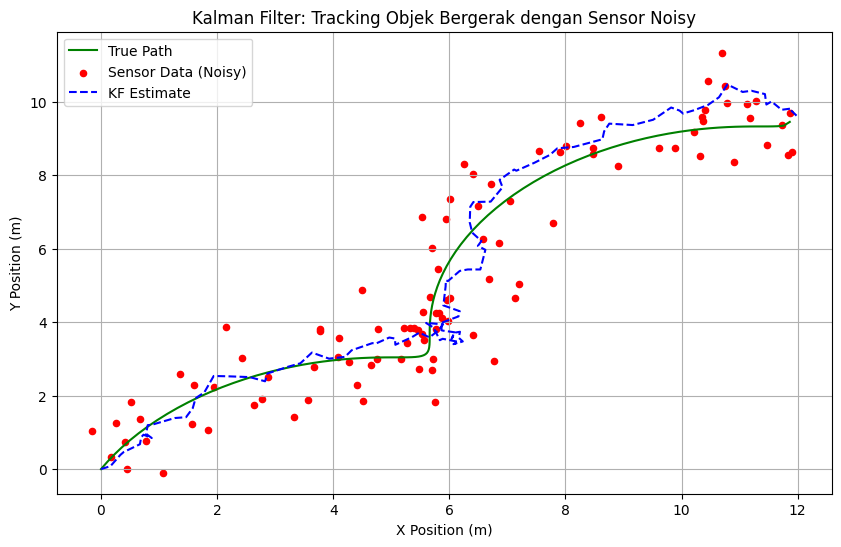

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fungsi Model Gerak (Linear)
def motion_model(state, dt):
    # State: [posisi_x, kecepatan_x, posisi_y, kecepatan_y]
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ])
    return F @ state

# Model Pengamatan (Hanya Posisi)
def measurement_model(state):
    return np.array([state[0], state[2]])  # [posisi_x, posisi_y]

# Jacobian untuk Pengamatan
def jacobian_measurement():
    return np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ])

# Inisialisasi Variabel
dt = 0.1  # Timestep
state = np.array([0, 1, 0, 1])  # [pos_x, vel_x, pos_y, vel_y]
covariance = np.eye(4) * 0.1  # Covariance Matrix
process_noise = np.eye(4) * 0.01  # Proses noise (Q)
measurement_noise = np.eye(2) * 0.5  # Noise sensor posisi (R)

# Simulasi Data
np.random.seed(42)
true_states = [state]
measurements = []

for t in range(100):
    # Gerak objek sebenarnya (sinusoidal)
    state[0] += np.sin(0.1 * t) * 0.1  # Posisi X
    state[2] += np.cos(0.1 * t) * 0.1  # Posisi Y
    state = motion_model(state, dt)
    true_states.append(state)

    # Sensor membaca posisi dengan noise
    measurement = measurement_model(state) + np.random.multivariate_normal([0, 0], measurement_noise)
    measurements.append(measurement)

# Jalankan Kalman Filter
estimated_states = [np.array([0, 1, 0, 1])]
for i in range(len(measurements)):
    # Predict step
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ])
    state_pred = F @ estimated_states[-1]
    covariance_pred = F @ covariance @ F.T + process_noise

    # Update step
    z = measurements[i]
    H = jacobian_measurement()
    y = z - H @ state_pred
    S = H @ covariance_pred @ H.T + measurement_noise
    K = covariance_pred @ H.T @ np.linalg.inv(S)

    state_est = state_pred + K @ y
    covariance = (np.eye(4) - K @ H) @ covariance_pred
    estimated_states.append(state_est)

# Plot Hasil
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 2], 'g-', label='True Path')  # Jalur sebenarnya
plt.scatter(measurements[:, 0], measurements[:, 1], c='r', s=20, label='Sensor Data (Noisy)')  # Data Sensor
plt.plot(estimated_states[:, 0], estimated_states[:, 2], 'b--', label='KF Estimate')  # Estimasi KF
plt.legend()
plt.title("Kalman Filter: Tracking Objek Bergerak dengan Sensor Noisy")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()


Hasil Analisis Output: Hasil simulasi **Tracking Objek Bergerak dengan Kalman Filter** menunjukkan bahwa filter ini mampu memberikan estimasi posisi yang mendekati jalur sebenarnya dari objek yang bergerak dengan pola sinusoidal. Jalur sebenarnya (True Path) yang ditampilkan oleh garis hijau menjadi acuan utama, sementara data sensor (titik merah) terlihat menyebar acak di sekitar jalur tersebut akibat noise. Estimasi Kalman Filter (garis putus-putus biru) berhasil memanfaatkan data sensor yang bising untuk menghasilkan estimasi posisi yang lebih halus dan akurat, mendekati jalur sebenarnya. Hal ini menunjukkan bahwa Kalman Filter efektif dalam mengurangi dampak noise dan memberikan estimasi yang optimal untuk pelacakan objek bergerak.


# Tracking Drone dengan Gerakan Parabola

Tujuan: Drone terbang dengan gerakan parabola di 2D.
Sensor hanya memberikan data posisi drone (x, y) dengan noise.
Kalman Filter digunakan untuk memperkirakan posisi dan kecepatan drone.

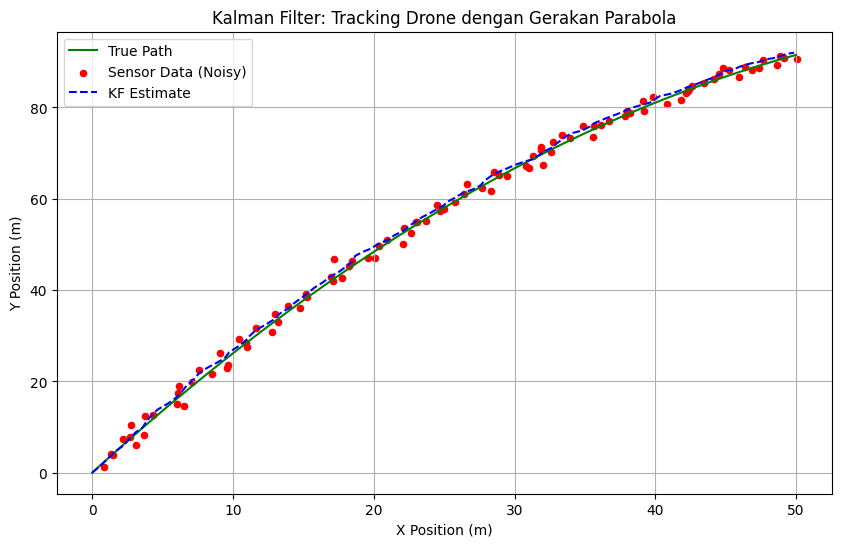

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fungsi Model Gerak
def motion_model(state, dt):
    # State: [posisi_x, kecepatan_x, posisi_y, kecepatan_y]
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ])
    return F @ state

# Model Pengamatan (Hanya Posisi)
def measurement_model(state):
    return np.array([state[0], state[2]])  # [posisi_x, posisi_y]

# Jacobian untuk Pengamatan
def jacobian_measurement():
    return np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ])

# Inisialisasi Variabel
dt = 0.1  # Timestep
state = np.array([0, 5, 0, 15])  # [pos_x, vel_x, pos_y, vel_y]
covariance = np.eye(4) * 0.1  # Covariance Matrix
process_noise = np.eye(4) * 0.01  # Proses noise (Q)
measurement_noise = np.eye(2) * 0.5  # Noise sensor posisi (R)

# Simulasi Data
np.random.seed(42)
true_states = [state]
measurements = []

for t in range(100):
    # Gerakan parabola: Y dipengaruhi gravitasi
    state[3] -= 0.98 * dt  # Gravitasi (penurunan kecepatan Y)
    state = motion_model(state, dt)
    true_states.append(state)

    # Sensor membaca posisi dengan noise
    measurement = measurement_model(state) + np.random.multivariate_normal([0, 0], measurement_noise)
    measurements.append(measurement)

# Jalankan Kalman Filter
estimated_states = [np.array([0, 5, 0, 15])]
for i in range(len(measurements)):
    # Predict step
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ])
    state_pred = F @ estimated_states[-1]
    covariance_pred = F @ covariance @ F.T + process_noise

    # Update step
    z = measurements[i]
    H = jacobian_measurement()
    y = z - H @ state_pred
    S = H @ covariance_pred @ H.T + measurement_noise
    K = covariance_pred @ H.T @ np.linalg.inv(S)

    state_est = state_pred + K @ y
    covariance = (np.eye(4) - K @ H) @ covariance_pred
    estimated_states.append(state_est)

# Plot Hasil
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 2], 'g-', label='True Path')  # Jalur sebenarnya
plt.scatter(measurements[:, 0], measurements[:, 1], c='r', s=20, label='Sensor Data (Noisy)')  # Data Sensor
plt.plot(estimated_states[:, 0], estimated_states[:, 2], 'b--', label='KF Estimate')  # Estimasi KF
plt.legend()
plt.title("Kalman Filter: Tracking Drone dengan Gerakan Parabola")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()

Hasil Analisis Output: Hasil simulasi **Tracking Drone dengan Gerakan Parabola menggunakan Kalman Filter** menunjukkan bahwa filter ini mampu memberikan estimasi posisi drone yang akurat meskipun data sensor mengandung noise. Jalur sebenarnya (True Path) yang ditampilkan oleh garis hijau mencerminkan gerakan drone dengan pola parabola yang dipengaruhi gravitasi, sedangkan data sensor (titik merah) menunjukkan penyebaran yang signifikan akibat noise. Estimasi posisi oleh Kalman Filter (garis putus-putus biru) mendekati jalur sebenarnya dengan hasil yang lebih halus dan konsisten dibandingkan data sensor. Hal ini membuktikan bahwa Kalman Filter efektif dalam mengurangi dampak noise sensor dan menghasilkan estimasi yang optimal untuk pelacakan drone dengan gerakan parabola.